In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import pwlf
import pathlib
import math
import numpy as np

In [20]:
src = pathlib.Path().cwd().parent.parent / 'data' / 'processed'

In [86]:
no_positive = pd.read_csv(src / 'no-positive' / 'no-positive.csv', index_col=0)
no_positive_by_adh = pd.read_csv(src / 'no-positive-by-group' / 'no-positive-by-adh.csv')
no_positive_by_ag = pd.read_csv(src / 'no-positive-by-group' / 'no-positive-by-ag.csv')
no_positive_by_sex = pd.read_csv(src / 'no-positive-by-group' / 'no-positive-by-sex.csv')

In [87]:
no_positive

,no_positive,no_positive_ppop,no_positive_rollmean7d,no_positive_ppop_rollmean7d,no_positive_cumsum,no_positive_ppop_cumsum
2021-05-27,2,0.022,NaN,NaN,2,0.022
2021-05-28,9,0.100,NaN,NaN,11,0.122
2021-05-29,21,0.234,NaN,NaN,32,0.356
2021-05-30,6,0.067,NaN,NaN,38,0.423
2021-05-31,8,0.089,NaN,NaN,46,0.512
...,...,...,...,...,...,...
2021-09-15,4595,51.095,5140.142857,57.156714,374970,4169.544
2021-09-16,4960,55.154,5092.142857,56.623000,379930,4224.698
2021-09-17,4270,47.481,4943.857143,54.974143,384200,4272.179
2021-09-18,4953,55.076,4863.714286,54.083000,389153,4327.255


In [88]:
no_positive.index = pd.to_datetime(no_positive.index)

In [89]:
# shift left
no_positive['no_positive_rollmean7d_sl'] = no_positive.no_positive_rollmean7d.shift(-3)
# no_positive['no_positive_sl'] = no_positive.no_positive.shift(-10)
no_positive = no_positive.loc[:'2021-09-16',]

In [90]:
no_positive.tail()
# no_positive_by_adh

,no_positive,no_positive_ppop,no_positive_rollmean7d,no_positive_ppop_rollmean7d,no_positive_cumsum,no_positive_ppop_cumsum,no_positive_rollmean7d_sl
2021-09-12,5143,57.188,5537.000000,61.569571,360250,4005.862,5140.142857
2021-09-13,4988,55.465,5396.142857,60.003286,365238,4061.327,5092.142857
2021-09-14,5137,57.122,5259.857143,58.487857,370375,4118.449,4943.857143
2021-09-15,4595,51.095,5140.142857,57.156714,374970,4169.544,4863.714286
2021-09-16,4960,55.154,5092.142857,56.623000,379930,4224.698,4845.428571


In [26]:
# Plot no_case
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.plot(no_case.index, no_case.no_case, linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [27]:
# Plot log no_case
# fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot(no_case.index, (no_case.no_case_rollmean7d).transform(math.log), linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# # ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [91]:
# Model config
beta_dict = {}
slope_dict = {}
x_dict = {}
y_dict = {}
x_hat_dict = {}
y_hat_dict = {}
predicted_var_dict = {}
ub_dict = {}
lb_dict = {}
xlabels_dict = {}
plot_title_dict = {}
no_positive_col = 'no_positive_rollmean7d_sl'
forecast_horizon = 20
policy_change = [no_positive.index.min(),
                 '2021-05-31', # chi thi 15, 16
                 '2021-06-14', # chi thi 15
                 '2021-06-19', # chi thi 10
                 '2021-07-09', # chi thi 16
                 '2021-07-19', # chi thi 16
                 '2021-07-27', # ngung xn hang loat
                 '2021-08-01', # chi thi 16
                 '2021-08-10', # quan huyen k fit
                 '2021-08-15',
                 '2021-08-23', # phong toa
                 no_positive.index.max()
                ]

In [92]:
# Forecast no_positive
# forecast_horizon = 15
# policy_change = [no_positive.index.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
#                  '2021-07-09', '2021-07-19', '2021-08-01', no_positive.index.max()]

x = (no_positive.index - no_positive.index.min()) / pd.Timedelta(1, unit='d')
y = no_positive[no_positive_col].replace(0, np.nan).transform(math.log).fillna(0)
x0 = (pd.to_datetime(policy_change) - no_positive.index.min()) / pd.Timedelta(1, unit='d')
xlabels = pd.date_range(
    no_positive.index.min(),
    no_positive.index.max() + pd.Timedelta(days=forecast_horizon-1)
).strftime('%d-%m')

model = pwlf.PiecewiseLinFit(x, y)
model.fit_with_breaks(x0)

x_hat = np.arange(min(x), max(x) + forecast_horizon)
y_hat = model.predict(x_hat)

predicted_var = model.prediction_variance(x_hat)
ub = y_hat + 1.96*np.sqrt(predicted_var)
lb = y_hat - 1.96*np.sqrt(predicted_var)

# Add result to dict
beta_dict['tphcm'] = list(model.beta)
slope_dict['tphcm'] = list(model.calc_slopes())
x_dict['tphcm'] = list(x)
y_dict['tphcm'] = list(y)
x_hat_dict['tphcm'] = list(x_hat)
y_hat_dict['tphcm'] = list(y_hat)
predicted_var_dict['tphcm'] = list(predicted_var)
ub_dict['tphcm'] = list(ub)
lb_dict['tphcm'] = list(lb)
xlabels_dict['tphcm'] = list(xlabels)
plot_title_dict['tphcm'] = 'TP HCM'

In [93]:
# dir(model)
# slope_dict
model.r_squared()

0.9939175909693737

In [31]:
# beta_dict['tphcm']

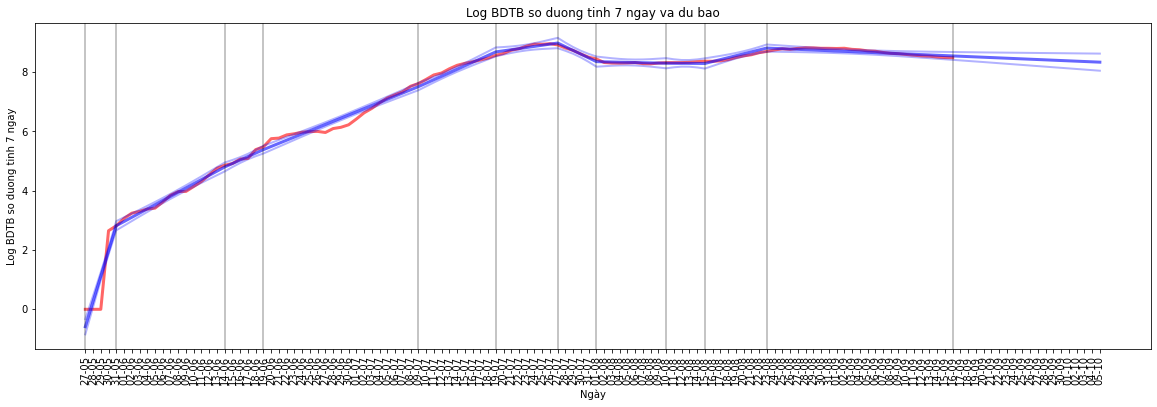

In [95]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel('Log BDTB so duong tinh 7 ngay')
ax.set_xlabel('Ngày')
ax.set_title('Log BDTB so duong tinh 7 ngay va du bao')
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)

xlabels = pd.date_range(
    no_positive.index.min(),
    no_positive.index.max() + pd.Timedelta(days=forecast_horizon - 1)
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)

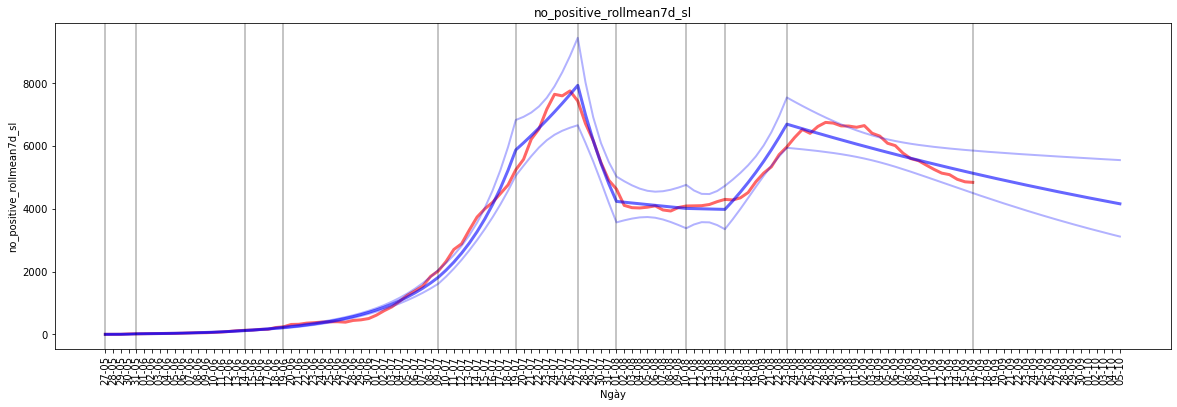

In [94]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
# ax.plot(x, no_positive.no_positive_sl, linewidth=3, color='orange', alpha=0.5)
ax.plot(x_hat,  np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat,  np.exp(ub), linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat,  np.exp(lb), linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel(no_positive_col)
ax.set_title(no_positive_col)
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)
ax.set_xlabel('Ngày')
xlabels = pd.date_range(
    no_positive.index.min(),
    no_positive.index.max() + pd.Timedelta(days=forecast_horizon -1 )
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)
# ax.set_ylim([0, 10000])

In [34]:
# np.exp(y_hat_dict['tphcm'][101])
# np.exp(ub_dict['tphcm'][101])
# np.exp(lb_dict['tphcm'][101])
# xlabels_dict['tphcm'][107]
# rs = model.r_squared()
# rs

In [35]:
# no_case_by_adh[(no_case_by_adh.addr_dist_home == 'HUYEN BINH CHANH')
#                & (no_case_by_adh.date_report > '2021-06-30')]
# foo['no_case_rollmean7d_sl'] = foo.no_case_rollmean7d.shift(-10)
# foo = foo.set_index('date_report')
# foo = foo.loc[:'2021-08-11',]
# foo.tail(15)
# foo = list(no_case_by_adh['addr_dist_home'].unique())
# foo = foo.sort()
# sorted(foo)

In [96]:
# Forecast log no_positive by adh
def forecast_no_positive_by_group(data, group, no_positive_col, forecast_horizon=7):
    unique = list(data[group].unique())
    for u in unique:
        df = data[data[group] == u]
        df['no_positive_rollmean7d_sl'] = df.no_positive_rollmean7d.shift(-3) # for shift data only
        df['date_report'] = pd.to_datetime(df.date_report)
        df = df.set_index('date_report')
        df = df.loc[:'2021-09-16',] # for shift data only
#         df.loc[:,'date_report'] = pd.to_datetime(df.index)
        key = u.lower().replace(' ', '')
#     output_dir = src / 'predicted-no-case-from-no-case-data'
#     prefix_1 = 'predicted-log-no-case-'
#     prefix_2 = 'by-adh-'
#     filename = prefix_1 + prefix_2 + u.lower().replace(' ', '') + '.png'
        # Run model PiecewiseLinFit with policy_change break
        x = (df.index - df.index.min()) / pd.Timedelta(1, unit='d')
        y = df[no_positive_col].replace(0, np.nan).transform(math.log).fillna(0)
        x0 = (pd.to_datetime(policy_change) - df.index.min()) / pd.Timedelta(1, unit='d')
        xlabels = pd.date_range(
            df.index.min(),
            df.index.max() + pd.Timedelta(days=forecast_horizon-1)
        ).strftime('%d-%m')
        model = pwlf.PiecewiseLinFit(x, y)
        model.fit_with_breaks(x0)
        x_hat = np.arange(min(x), max(x) + forecast_horizon)
        y_hat = model.predict(x_hat)
        predicted_var = model.prediction_variance(x_hat)
        ub = y_hat + 1.96*np.sqrt(predicted_var)
        lb = y_hat - 1.96*np.sqrt(predicted_var)
        # Save result to dict
        beta_dict[key] = list(model.beta)
        slope_dict[key] = list(model.calc_slopes())
        x_dict[key] = list(x)
        y_dict[key] = list(y)
        x_hat_dict[key] = list(x_hat)
        y_hat_dict[key] = list(y_hat)
        predicted_var_dict[key] = list(predicted_var)
        ub_dict[key] = list(ub)
        lb_dict[key] = list(lb)
        xlabels_dict[key] = list(xlabels)
        plot_title_dict[key] = u

def plot_forecast_no_positive_by_group(exp=True, sharex=True, nrow=8, ncol=3, 
                                   xstart=1, xend=25, ylim=700, figsize=(18, 20)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    plt.tight_layout(h_pad=5)
#     fig.suptitle('Title here')
    keys = sorted(list(x_dict.keys())[xstart:xend])
    if exp:
        for k in range(len(keys)):
            r = k // ncol
            c = k % ncol
            ax[r, c].plot(x_dict[keys[k]], np.exp(y_dict[keys[k]]), linewidth=2, color='red', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(y_hat_dict[keys[k]]), linewidth=2, color='blue', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(ub_dict[keys[k]]), linewidth=1, color='blue', alpha=0.3)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(lb_dict[keys[k]]), linewidth=1, color='blue', alpha=0.3)
            ax[r, c].fill_between(x_hat_dict[keys[k]], np.exp(lb_dict[keys[k]]), np.exp(ub_dict[keys[k]]),
                                  color='blue', alpha=0.1)
            ax[r, c].title.set_text(plot_title_dict[keys[k]])
            ax[r, c].set_ylim([0, ylim])
    #         ax[r, c].set_ylabel('Log Số ca mới')
    #         ax[r, c].set_xlabel('Ngày')
            ax[r, c].set_xticks(x_hat_dict[keys[k]])
            ax[r, c].set_xticklabels(xlabels_dict[keys[k]])
            ax[r, c].tick_params(axis='x', labelrotation=90)
            ax[r, c].locator_params(tight=True, nbins=11)

    else:
        for k in range(len(keys)):
            r = k // ncol
            c = k % ncol
            ax[r, c].plot(x_dict[keys[k]], y_dict[keys[k]], linewidth=2, color='red', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], y_hat_dict[keys[k]], linewidth=2, color='blue', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], ub_dict[keys[k]], linewidth=1, color='blue', alpha=0.3)
            ax[r, c].plot(x_hat_dict[keys[k]], lb_dict[keys[k]], linewidth=1, color='blue', alpha=0.3)
            ax[r, c].fill_between(x_hat_dict[keys[k]], lb_dict[keys[k]], ub_dict[keys[k]], color='blue', alpha=0.1)
            ax[r, c].title.set_text(plot_title_dict[keys[k]])
            ax[r, c].set_ylim([0, ylim])
            ax[r, c].set_xticks(x_hat_dict[keys[k]])
            ax[r, c].set_xticklabels(xlabels_dict[keys[k]])
            ax[r, c].tick_params(axis='x', labelrotation=90)
            ax[r, c].locator_params(tight=True, nbins=11)
        
# DO NOT DELETE THIS
#     fig, ax = plt.subplots(figsize=(20, 6))
#     ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
#     ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
#     ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
#     ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
#     ax.set_ylabel('Log Số ca mới')
#     ax.set_xlabel('Ngày')
#     ax.set_xticks(x_hat)
#     ax.set_xticklabels(xlabels)
#     ax.tick_params(axis='x', labelrotation=90)
#     ax.set_title('Log số ca mới & Log số ca mới dự báo ' + u)
#     for i in x0:
#         ax.axvline(i, color='black', alpha=0.3)

#     plt.savefig(
#         output_dir / filename,
#         transparent = True)
#     plt.close(fig)



<ipython-input-96-6ad24bb76ace>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_positive_rollmean7d_sl'] = df.no_positive_rollmean7d.shift(-3) # for shift data only
<ipython-input-96-6ad24bb76ace>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


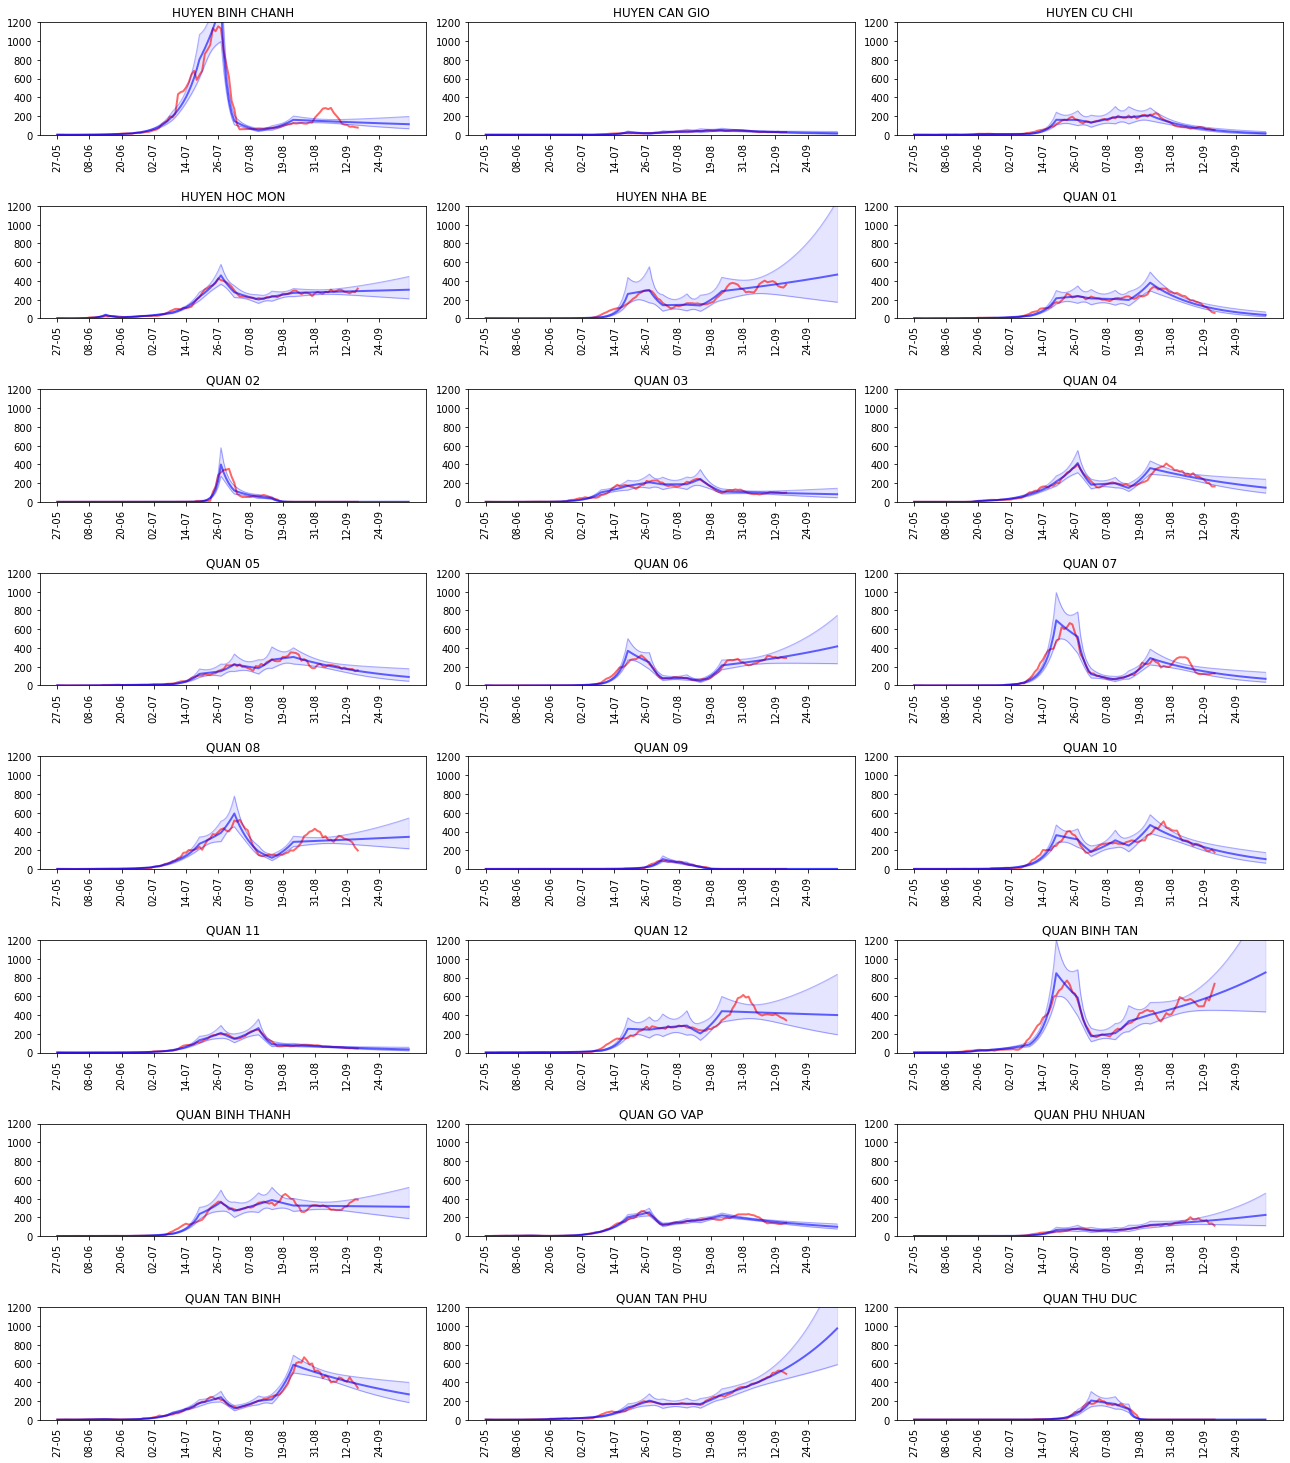

In [97]:
forecast_no_positive_by_group(
    no_positive_by_adh,
    no_positive_col=no_positive_col,
    group='addr_dist_home',
    forecast_horizon=forecast_horizon)
plot_forecast_no_positive_by_group(ylim=1200)

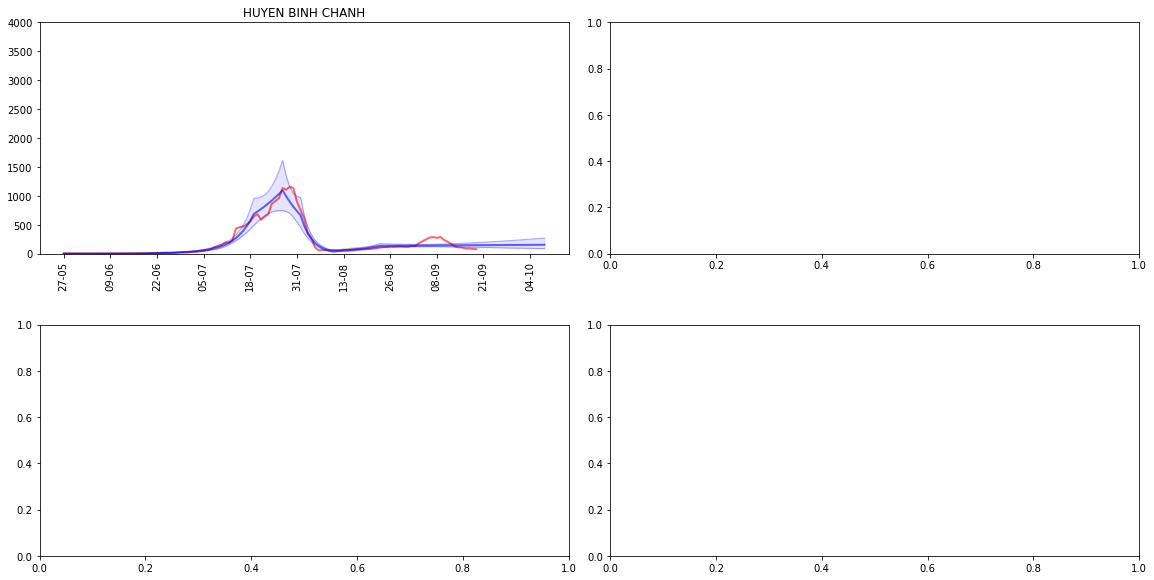

In [39]:
plot_forecast_no_positive_by_group(nrow=2, ncol=2, xstart=22, xend=23, ylim=4000, figsize=(16, 8))

<ipython-input-96-6ad24bb76ace>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_positive_rollmean7d_sl'] = df.no_positive_rollmean7d.shift(-3) # for shift data only
<ipython-input-96-6ad24bb76ace>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


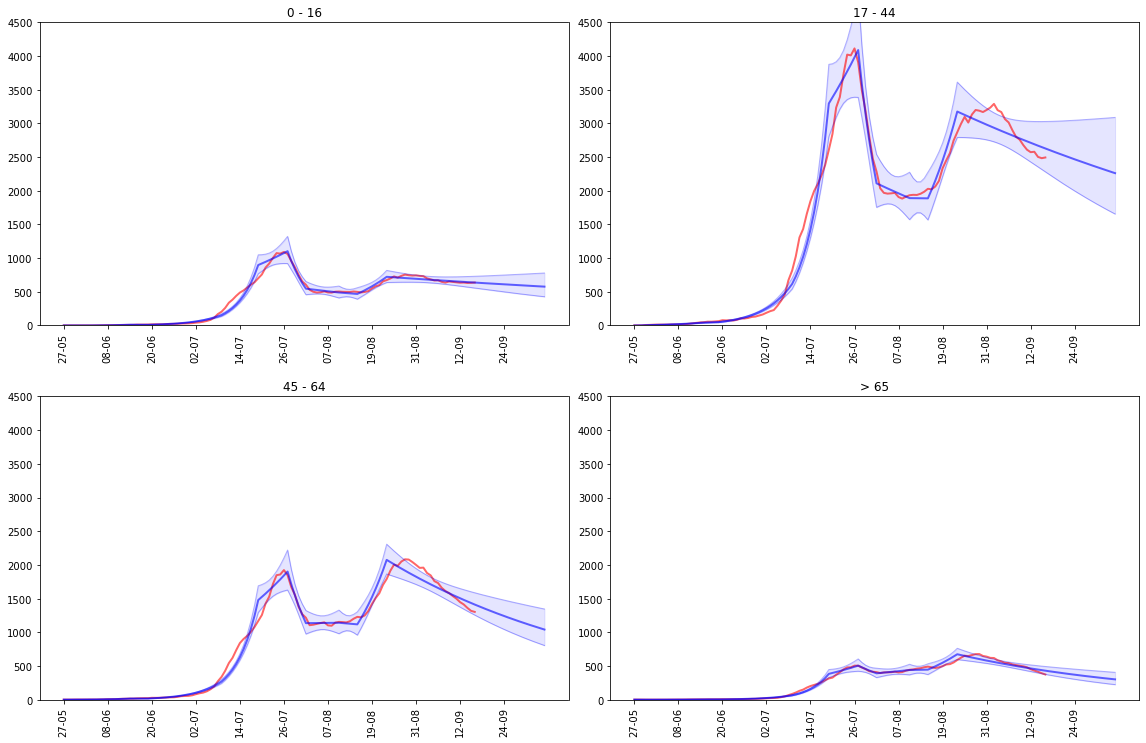

In [98]:
forecast_no_positive_by_group(
    no_positive_by_ag,
    no_positive_col=no_positive_col,
    group='age_group',
    forecast_horizon=forecast_horizon)
plot_forecast_no_positive_by_group(nrow=2, ncol=2, xstart=25, xend=29, ylim=4500, figsize=(16, 10))

<ipython-input-36-10bba03474d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


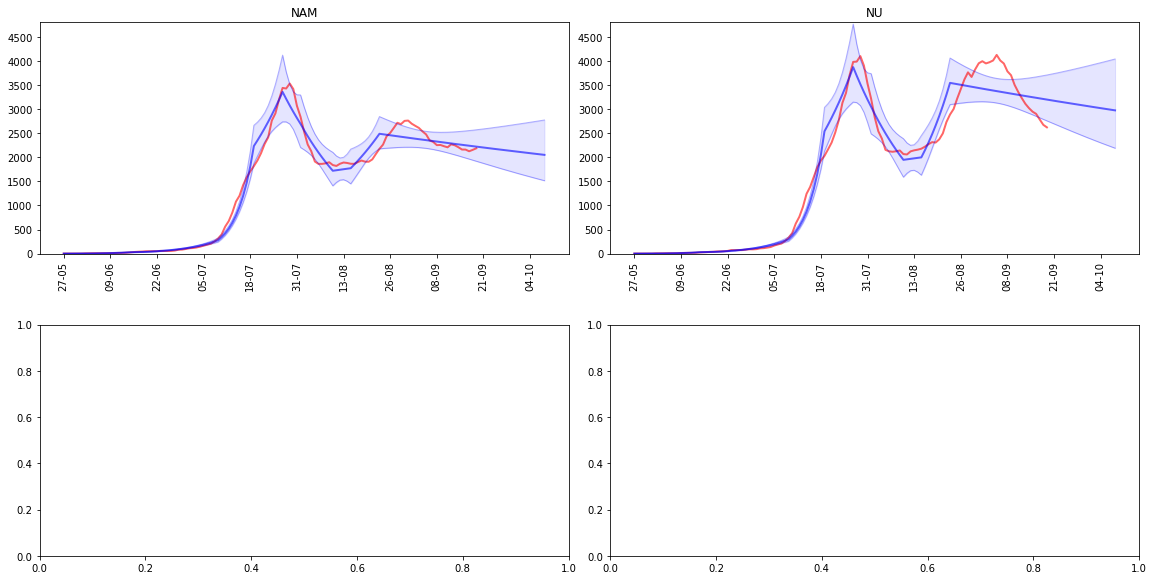

In [44]:
forecast_no_positive_by_group(
    no_positive_by_sex,
    no_positive_col=no_positive_col,
    group='sex',
    forecast_horizon=forecast_horizon)

plot_forecast_no_positive_by_group(nrow=2, ncol=2, xstart=29, xend=31, ylim=4800, figsize=(16, 8))


In [46]:
# y hat, ub, lb ngay 04/09
# foo_yhat = np.exp(pd.DataFrame(y_hat_dict))
# foo_ub = np.exp(pd.DataFrame(ub_dict))
# foo_lb = np.exp(pd.DataFrame(lb_dict))
# pd.to_datetime(x_hat_dict).strftime('%d-%m-%Y')[:-1]
# predicted_no_positive = pd.concat([foo_yhat.loc[100], foo_ub.loc[100], foo_lb.loc[100]], axis=1)
# predicted_no_positive.columns = ['y_hat', 'ci_lower', 'ci_upper']
# predicted_no_positive
# predicted_no_positive.to_csv(src / 'predicted-no-case-from-no-case-data' / 'predicted-no-case-2021-09-04.csv')
# xlabels_dict['tphcm'][100]

In [47]:
slope = pd.DataFrame(slope_dict).transpose()
slope.columns = pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]
r0 = np.exp(slope)

# slope.to_csv(src / 'predicted-no-positive-from-no-positive' / 'slope.csv')
# r0.to_csv(src / 'predicted-no-positive-from-no-positive' / 'r0.csv')
# slope
r0

,27-05-2021,31-05-2021,14-06-2021,19-06-2021,09-07-2021,19-07-2021,27-07-2021,01-08-2021,10-08-2021,15-08-2021,23-08-2021
tphcm,1.474453,1.294477,1.059678,1.108472,1.138365,1.069553,0.942359,0.952199,1.004876,1.060330,0.995857
quan01,0.732009,1.050539,1.302702,1.082609,1.275786,1.044929,0.994482,0.985851,0.992551,1.079949,0.959142
quan12,1.058061,1.017957,1.161794,1.044404,1.409535,0.977749,1.067380,1.003105,0.956462,1.061389,1.008708
quanthuduc,1.000469,0.999646,1.005560,0.995797,1.205015,1.177648,1.519059,0.980132,1.233105,0.490412,0.979995
quan09,1.000576,0.999566,1.006824,0.994848,1.122348,1.146645,1.568941,0.980568,1.015718,0.599038,0.987574
quangovap,1.115901,1.131268,0.762408,1.129830,1.212209,1.064369,0.911000,0.975393,1.045558,1.034612,0.986349
quanbinhthanh,1.041033,1.038020,0.944499,1.102311,1.350866,1.042656,1.024276,0.989573,1.048872,0.992170,0.995683
quantanbinh,0.932652,1.126903,0.826063,1.166275,1.142435,1.082579,0.902701,0.998134,1.049044,1.123208,0.994963
quantanphu,0.728163,1.031274,1.519520,1.079878,1.170642,1.061883,1.006735,0.991685,0.984688,1.052639,1.032678
quanphunhuan,1.048769,0.956805,0.755215,1.136019,1.433659,0.966108,1.081658,0.957598,1.038531,1.063366,1.017997


In [132]:
pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]

Index(['27-05-2021', '31-05-2021', '14-06-2021', '19-06-2021', '09-07-2021',
       '19-07-2021', '01-08-2021', '15-08-2021'],
      dtype='object')

In [21]:
# TODO fix this plot
# Forecast no_case by adh
unique = list(no_case_by_adh.addr_dist_home.unique())
for u in unique:
    df = no_case_by_adh[no_case_by_adh.addr_dist_home == u]
    df.loc[:,'date_report'] = pd.to_datetime(df.date_report)
    forecast_horizon = 15
    policy_change = [df.date_report.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
                     '2021-07-09', '2021-07-19', '2021-08-01', df.date_report.max()]

    output_dir = src / 'predicted-no-case-from-no-case-data'
    prefix_1 = 'predicted-no-case-'
    prefix_2 = 'by-adh-'
    filename = prefix_1 + prefix_2 + u.lower().replace(' ', '') + '.png'

    x = (df.date_report - df.date_report.min()) / pd.Timedelta(1, unit='d')
    y = df.no_case_ppop_rollmean7d.replace(0, np.nan).transform(math.log).fillna(0)
    x0 = (pd.to_datetime(policy_change) - df.date_report.min()) / pd.Timedelta(1, unit='d')
    xlabels = pd.date_range(
        df.date_report.min(),
        df.date_report.max() + pd.Timedelta(days=forecast_horizon-1)
    ).strftime('%d-%m')

    model = pwlf.PiecewiseLinFit(x, y)
    model.fit_with_breaks(x0)

    x_hat = np.arange(min(x), max(x) + forecast_horizon)
    y_hat = model.predict(x_hat)

    predicted_var = model.prediction_variance(x_hat)
    ub = y_hat + 1.96*np.sqrt(predicted_var)
    lb = y_hat - 1.96*np.sqrt(predicted_var)

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
    ax.plot(x_hat, np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
    ax.plot(x_hat, np.exp(ub), linewidth=2, color='blue', alpha=0.3)
    ax.plot(x_hat, np.exp(lb), linewidth=2, color='blue', alpha=0.3)
    ax.set_ylabel('Số ca mới')
    ax.set_xlabel('Ngày')
    ax.set_xticks(x_hat)
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title('Số ca mới & Số ca mới dự báo ' + u)
    for i in x0:
        ax.axvline(i, color='black', alpha=0.3)

    plt.savefig(
        output_dir / filename,
        transparent = True)
    plt.close(fig)

/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [29]:
# Forecast no_case by adh
for key in y_hat_dict.keys():
    output_dir = src / 'predicted-no-case-from-no-case-data'
    prefix_1 = 'predicted-no-case-'
    prefix_2 = 'by-adh-'
    filename = prefix_1 + prefix_2 + plot_title_dict[key].lower().replace(' ', '') + '.png'
    x = x_dict[key]
    y = y_dict[key]
    x_hat = x_hat_dict[key]
    y_hat = y_hat_dict[key]
    ub = ub_dict[key]
    lb = lb_dict[key]
    title = plot_title_dict[key]
    xlabels = xlabels_dict[key]

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
    ax.plot(x_hat, np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
    ax.plot(x_hat, np.exp(ub), linewidth=2, color='blue', alpha=0.3)
    ax.plot(x_hat, np.exp(lb), linewidth=2, color='blue', alpha=0.3)
    ax.set_ylabel('Số ca mới')
    ax.set_xlabel('Ngày')
    ax.set_xticks(x_hat)
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title('Số ca mới & Số ca mới dự báo ' + plot_title_dict[key])
    for i in x0:
        ax.axvline(i, color='black', alpha=0.3)

    plt.savefig(
        output_dir / filename,
        transparent = True)
    plt.close(fig)

In [25]:
for key in y_hat_dict.keys():
    print(key)

tphcm
quan01
quan12
quanthuduc
quan09
quangovap
quanbinhthanh
quantanbinh
quantanphu
quanphunhuan
quan02
quan03
quan10
quan11
quan04
quan05
quan06
quan08
quanbinhtan
quan07
huyencuchi
huyenhocmon
huyenbinhchanh
huyennhabe
huyencangio


In [30]:
# np.exp(y_hat)[82]
# np.exp(ub)[82]
# np.exp(lb)[82]

In [49]:
y_hat[82]

7.913757636719259